# Import

In [1]:
import sys
sys.path.append('/home/aistudio/external-libraries')

import jax
import jax.numpy as jnp
import jax.random as random
import optax
import jaxopt
import numpy as np

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
from scipy.stats import qmc
import time
import pandas as pd
import process_log
import os
import shutil
from ddeint import ddeint


font_path = '/home/aistudio/external-libraries/Times_New_Roman.ttf'
path = '/home/aistudio/PINN-PDDEs/PD-ODE'
prop = font_manager.FontProperties(fname=font_path)

picture_path = os.path.join(path, 'ODE_FP_ex3_picture_result')
os.makedirs(picture_path, exist_ok=True)
result_path = os.path.join(path, 'ODE_FP_ex3_result')
os.makedirs(result_path, exist_ok=True)

log_path = os.path.join(result_path, 'log')
os.makedirs(log_path, exist_ok=True)

# Configuration

In [2]:
# config = {
#     "q": 0.5,
#     "tmin": 0.,
#     "tmax": 1.,
#     "netLayers": [1, 20, 40, 20, 1],
#     "activation_function": 1,
#     "N_f": 5000,
#     "step_epochs": [5001, 10001],
# #    "step_epochs": [2, 4],
#     "initial_key": 0,
#     "log_path": os.path.join(log_path,f"log.txt"),
#     "picture_path": picture_path
# }
# results = []

# Definition of the equation and its exact solution
The considered equation is as follows:
$$
\begin{cases}
\frac{1}{2}q^{2}y''(qt) + \frac{21}{2}q\frac{y'(qt)}{t} + y(t)^{2} = t^{8} + 48 q^{4}t^{2}, \\
y(0) = 0,\
y'(0) = 0.
\end{cases}
$$
The analytical solution of this equation is:
$$
  u(t)=t^{4}
$$

In [3]:
for key, value in config.items():
    globals()[key] = value

    def PDDE(t, u):
    # Define u'(t) and u''(t)
        u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)))(t)
        u_tt = lambda t: jax.grad(lambda t: jnp.sum(u_t(t)))(t)

        rhs = t**9 + 48*q**4 * t**3 
        return 0.5 * q**2 * t * u_tt(q*t) + 21/2 * q* u_t(q*t) + t * u(t)**2 - rhs

    def u_bound1(t_c):
        return 0 

    def u_bound2(t_c):
        return 0 

# exact solution
def u(t):
    return t ** 4

# Definition of the loss functions

In [4]:
def loss_fun1(params, inPoints):
    t_c = inPoints[:,[0]]
    ufunc = lambda t: DNNs(params, t)
    ufunc_t = lambda t: jax.grad(lambda t: jnp.sum(ufunc(t)))(t)

    loss_f = jnp.mean(PDDE(t_c, ufunc)**2)
    loss_i1 = jnp.mean((ufunc(tmin) - u_bound1(tmin))**2)
    loss_i2 = jnp.mean((ufunc_t(tmin) - u_bound2(tmin))**2)
    loss_i = jnp.mean(jnp.array([loss_i1, loss_i2]))

    all_losses = jnp.array([loss_f, loss_i])
    total_loss = jnp.sum(all_losses)
    weights = all_losses / total_loss
    loss_weighted = jnp.sum(all_losses * weights)
    return loss_weighted, all_losses

def loss_fun2(params, inPoints, initial_weights):
    t_c = inPoints[:,[0]]
    ufunc = lambda t: DNNs(params, t)
    ufunc_t = lambda t: jax.grad(lambda t: jnp.sum(ufunc(t)))(t)

    loss_f = jnp.mean(PDDE(t_c, ufunc)**2)
    loss_i1 = jnp.mean((ufunc(tmin) - u_bound1(tmin))**2)
    loss_i2 = jnp.mean((ufunc_t(tmin) - u_bound2(tmin))**2)
    loss_i = jnp.mean(jnp.array([loss_i1, loss_i2]))

    all_losses = jnp.array([loss_f, loss_i])
    loss_weighted = jnp.sum(all_losses * initial_weights)

    return loss_weighted, all_losses

# DNNs Model Definition and Parameter Initialization

In [5]:
def DNNs(params, t):
    def activate(t):
        if activation_function == 1:
            return jnp.tanh(t)
        elif activation_function == 2:
            return jnp.maximum(0, t)  # ReLU
        elif activation_function == 3:
            return 1 / (1 + jnp.exp(-t))  # Sigmoid
        elif activation_function == 4:
            return jnp.sin(t)

    for w, b in params[:-1]:
        t = jnp.dot(t, w) + b
        t = activate(t)

    w, b = params[-1]
    t = jnp.dot(t, w) + b
    return t

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    # Compute standard deviation for Xavier initialization
    xavier_stddev = jnp.sqrt(2.0 / (m + n))
    # Split random key for weights and biases
    w_key, b_key = jax.random.split(key)
    # Generate truncated normal weights (±2 standard deviations)
    weights = xavier_stddev * jax.random.truncated_normal(
        w_key, lower=-2.0, upper=2.0, shape=(m, n)
    )
    # Initialize biases to zero
    biases = jnp.zeros((n,))
    return weights, biases

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# Definition of the optimizers

In [6]:
def train_adam(
    params,
    loss_fn,
    loss_args: dict,
    solver_config: dict = None
):
    # Default optimizer configuration
    solver_config_defaults = {
        "init_value": 1e-3,
        "decay_steps": 1000,
        "alpha": 0.01,
        "num_epochs": 2000,
        "start_epoch": 0,
        "record_info": False,
        "log_interval": 10,
        "print_interval": 100
    }

    # Merge provided settings with defaults
    cfg = {**solver_config_defaults, **(solver_config or {})}

    # Initialize containers for logging
    phase_epochs, phase_losses, phase_loss_terms= [], [], []

    # Set up learning rate scheduler and optimizer
    scheduler = optax.cosine_decay_schedule(
        init_value=cfg['init_value'],
        decay_steps=cfg['decay_steps'],
        alpha=cfg['alpha']
    )
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state):
        (loss, all_losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, **loss_args)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, all_losses

    # Main training loop
    for epoch in range(cfg['num_epochs']):
        params, opt_state, loss, all_losses = update(params, opt_state)
        current_epoch = cfg['start_epoch'] + epoch

        # Log information
        if cfg['record_info'] and current_epoch % cfg['log_interval'] == 0:
            phase_epochs.append(current_epoch)
            phase_losses.append(loss)
            phase_loss_terms.append(all_losses)

        # Print training progress
        if cfg['record_info'] and current_epoch % cfg['print_interval'] == 0:
            print(f"Epoch {current_epoch}, Total Loss: {loss:.3e}")

    return (
        params,
        phase_epochs if cfg['record_info'] else None,
        phase_losses if cfg['record_info'] else None,
        phase_loss_terms if cfg['record_info'] else None,
        all_losses
    )

def train_lbfgs(
    params,
    loss_fn,
    loss_args: dict,
    solver_config: dict = None,
):
    if solver_config is None:
        solver_config = {}

    # Default optimizer configuration
    solver_config_defaults = {
        "tol": 1e-18,
        "maxiter": 10000,
        "verbose": False,
        "log_to_file": False,
        "logfile": "log.txt",
        "log_target_param": False
    }

    # Merge provided settings with defaults
    cfg = {**solver_config_defaults, **solver_config}

    # Wrap the objective function to match the BFGS signature
    def wrapped_loss_fn(p):
        return loss_fn(p, **loss_args)

    # Construct the custom BFGS solver
    solver = jaxopt.My_BFGS(
        fun=wrapped_loss_fn,
        has_aux=True,
        **cfg
    )

    sol = solver.run(params)
    return sol.params, sol.state.aux

# Initialization

In [7]:
# Generate random points
jaxKey = jax.random.PRNGKey(initial_key)
sampler = qmc.LatinHypercube(d=1)
sample = sampler.random(n=N_f)
scaled_sample = qmc.scale(sample, tmin, tmax)
inPoints = jnp.array(scaled_sample)

# Initialize network parameters
params = init_network_params(netLayers, jaxKey)

# Training

In [8]:
start_time_nn = time.time()

# Step 1: Adam optimizer
solver_config_adam = {
    "init_value": 1e-3,
    "decay_steps": 1000,
    "alpha": 0.01,
    "num_epochs": step_epochs[0],
    "start_epoch": 0,
    "record_info": True,
    "log_interval": 10,
    "print_interval": 1000
}

loss_args_adam = {
    "inPoints": inPoints,
}

params, hist1_epoch, hist1_loss, hist1_loss_terms, loss_components = train_adam(
    params,
    loss_fun1,
    loss_args_adam,
    solver_config_adam
)

losses = jax.lax.stop_gradient(loss_components)
initial_weights = losses / jnp.sum(losses)

# Step 2: LBFGS optimizer
solver_config_lbfgs = {
    "tol": 1e-16,
    "maxiter": step_epochs[1],
    "verbose": False,
    "log_to_file": True,
    "logfile": log_path,
    "log_target_param": False
}
loss_args_lbfgs = {
    "inPoints": inPoints,
    "initial_weights": initial_weights
}

params, _ = train_lbfgs(params, loss_fun2, loss_args_lbfgs, solver_config_lbfgs)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn

Epoch 0, Total Loss: 2.556e+00
Epoch 1000, Total Loss: 1.657e-02
Epoch 2000, Total Loss: 1.485e-02
Epoch 3000, Total Loss: 1.252e-02
Epoch 4000, Total Loss: 9.788e-03
Epoch 5000, Total Loss: 6.984e-03


# Calculation of the solution effect of DNNs and DDEINT 

In [9]:
# DNNs
T = np.linspace(tmin, tmax, 5000).reshape(-1, 1)
nn_sol = DNNs(params, T)
rr_sol = u(T)

nn_error = nn_sol - rr_sol
abs_error_nn_rr = np.abs(nn_error)
rel_error_nn_rr = np.linalg.norm(nn_error, ord=2) / np.linalg.norm(rr_sol, ord=2)
mae_nn_rr = np.mean(abs_error_nn_rr)


# record the result
result = {
    "netLayers": netLayers,
    "q": q,
    "N_f": N_f,
    # "activation_function": config["activation_function"],
    # "loss": loss,
    "RE": "{:.6e}".format(rel_error_nn_rr),
    "AE": "{:.6e}".format(mae_nn_rr),
    "time_nn": time_nn
}
print(result)
results.append(result)

{'netLayers': [1, 20, 40, 20, 1], 'q': 0.5, 'N_f': 5000, 'RE': '3.869753e-05', 'AE': '6.512471e-06', 'time_nn': 96.99085426330566}


# Visualization of numerical solutions

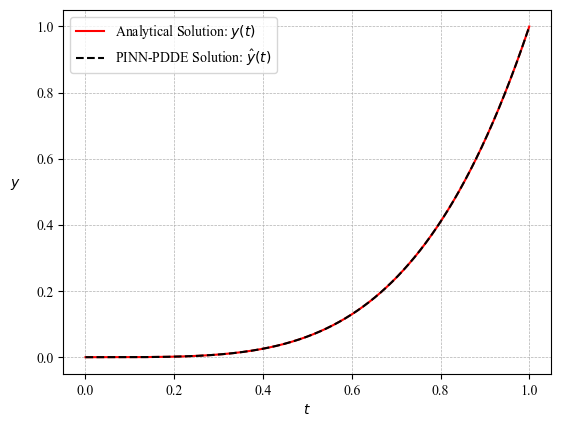

In [11]:
#Uniform image size
figsize = (16 / 2.54, 12 / 2.54)

fig = plt.figure(figsize=figsize)
plt.plot(T, rr_sol, '-r', label='Analytical Solution: $y(t)$')
plt.plot(T, nn_sol, '--k', label='PINN-PDDE Solution: $\hat{y}(t)$')
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y$', rotation=0, labelpad=15, fontproperties=prop)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(prop)
plt.legend(prop=prop, loc='best')                
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plot_path = os.path.join(picture_path, 'nn_solution.png')
plt.savefig(plot_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig)

# Visualization of numerical solution errors

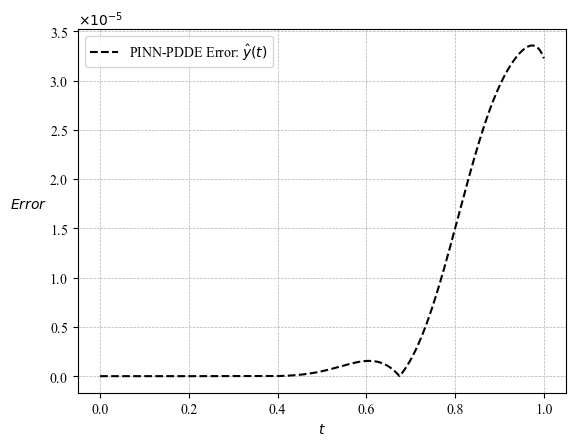

In [12]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))

fig = plt.figure(figsize=figsize)
plt.plot(T, abs_error_nn_rr, '--k', label='PINN-PDDE Error: $\hat{y}(t)$')
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$Error$', rotation=0, labelpad=15, fontproperties=prop)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(prop)
plt.legend(prop=prop, loc='best')         
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plot_path = os.path.join(picture_path, 'error_2d.png')
plt.savefig(plot_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig)


# Visualization of loss value changes

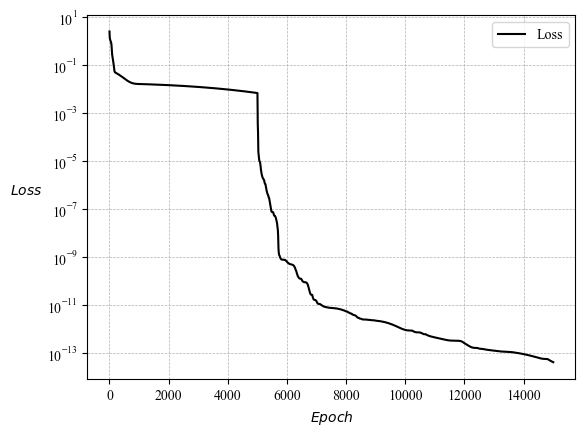

In [13]:
adam_arr, col_names = process_log.format_adam_log(hist1_epoch, hist1_loss)
bfgs_arr, col_names = process_log.extract_bfgs_info(log_path, step_epochs[0], 10)
all_arr = np.vstack([adam_arr, bfgs_arr])

epoch_history = all_arr[:, 0]
loss_history = all_arr[:, 1]

# Loss
fig = plt.figure(figsize=figsize)
plt.plot(epoch_history, loss_history, 'k', label='Loss')
plt.yscale('log')
plt.xlabel('$Epoch$', fontproperties=prop)
plt.ylabel('$Loss$', rotation=0, labelpad=15, fontproperties=prop)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontproperties(prop)
plt.legend(prop=prop, loc='best')                
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plot_path = os.path.join(picture_path, 'loss_history.png')
plt.savefig(plot_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close(fig)